In [5]:
import os, sys, glob
from tensorflow.keras import layers, models, optimizers
from sklearn.model_selection import train_test_split
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Conv1D
import tensorflow.keras.utils as conv_utils 
import tensorflow as tf
from tensorflow.keras.regularizers import l2
from sacred import Experiment
from tensorflow.keras.utils import plot_model

In [6]:
def asymmetric_temporal_padding(x, left_pad=1, right_pad=1):
    '''Pad the middle dimension of a 3D tensor
    with "left_pad" zeros left and "right_pad" right.
    '''
    pattern = [[0, 0], [left_pad, right_pad], [0, 0]]
    return tf.pad(x, pattern)


class CausalAtrousConvolution1D(Conv1D):
    def __init__(self, 
                 filters, 
                 kernel_size, 
                 strides=1, 
                 dilation_rate=1, 
                 init='glorot_uniform', 
                 padding='valid', 
                 activation=None,
                 bias_regularizer=None,
                 activity_regularizer=None, 
                 kernel_constraint=None,
                 bias_constraint=None, 
                 use_bias=True, 
                 causal=False, 
                 **kwargs):
        
        super(CausalAtrousConvolution1D, self).__init__(filters,
                                                        kernel_size=kernel_size,
                                                        strides=strides,
                                                        dilation_rate=dilation_rate,
                                                        padding=padding,
                                                        activation=activation,
                                                        use_bias=use_bias,
                                                        kernel_initializer=init,
                                                        activity_regularizer=activity_regularizer,
                                                        bias_regularizer=bias_regularizer,
                                                        kernel_constraint=kernel_constraint,
                                                        bias_constraint=bias_constraint,
                                                        **kwargs)

        self.causal = causal
        if self.causal and padding != 'valid':
            raise ValueError("Causal mode dictates border_mode=valid.")

    def compute_output_shape(self, input_shape):
        input_length = input_shape[1]

        if self.causal:
            input_length += self.dilation_rate[0] * (self.kernel_size[0] - 1)

        length = conv_output_length(input_length,
                                    self.kernel_size[0],
                                    self.padding,
                                    self.strides[0],
                                    dilation=self.dilation_rate[0])

        return (input_shape[0], length, self.filters)

    def call(self, x):
        if self.causal:
            x = asymmetric_temporal_padding(x, self.dilation_rate[0] * (self.kernel_size[0] - 1), 0)
        return super(CausalAtrousConvolution1D, self).call(x)

In [99]:
class WaveNet(tf.keras.Model):
    def __init__(self,
                 x_shape,
                 n_filters, 
                 n_categories,
                 n_residual_blocks,
                 mode='g',
                 use_skip_connections=True,
                 res_l2=0,
                 final_l2=0,
                 name='WaveNet',
                 **kwargs
                ):
        super(WaveNet, self).__init__(name=name, **kwargs)
        self.x_shape = x_shape
        self.n_filters = n_filters
        self.n_categories = n_categories
        self.n_residual_blocks = n_residual_blocks
        self.mode = mode,
        self.use_skip_connections=use_skip_connections,
        self.res_l2=res_l2
        self.final_l2=final_l2,

        self.blocks=[]
        for i in range(self.n_residual_blocks):
            block = self.residual_block(i, use_bias=False)
            self.blocks.append(block)
            
        self.model = self.build_model()
        
        
    def residual_block(self, i, use_bias=False):

        x = layers.Input(shape=(self.x_shape[0], self.n_filters), name='x_residual_%i'%i)
        f = CausalAtrousConvolution1D(self.n_filters, 2, 
                                      dilation_rate=2**i, 
                                      causal=True, 
                                      use_bias=use_bias,
                                      kernel_regularizer=l2(self.res_l2),
                                      name='f_%i'%i, 
                                      activation='tanh',
                                      )(x)

        g = CausalAtrousConvolution1D(self.n_filters, 2, 
                                      dilation_rate=2**i, 
                                      causal=True, 
                                      use_bias=use_bias,
                                      kernel_regularizer=l2(self.res_l2),
                                      name='g_%i'%i, 
                                      activation='sigmoid',
                                      )(x)

        z = layers.Multiply(name='multiply_%i'%i)([f,g])
        z = layers.Convolution1D(self.n_filters, 1, 
                                 padding='same', 
                                 use_bias=use_bias,
                                 kernel_regularizer=l2(self.res_l2),
                                 name = '1x1_conv_%i'%i,
                                 )(z)

        y = layers.Add(name='res_out_%i'%i)([x, z])
        block = models.Model(x, [y, z], name='Residual_Block_%i'%i)
        return block
    
    def generator_block(self, x):
                
        y = layers.Activation('relu', name='relu_1')(x)
        y = layers.Convolution1D(self.n_categories, 1, 
                                 padding='same',
                                 kernel_regularizer=l2(self.final_l2))(y)
        y = layers.Activation('relu', name='relu_2')(y)
        y = layers.Convolution1D(self.n_categories, 1, 
                                 padding='same')(y)
        y_out = layers.Activation('softmax', name='softmax')(y)

        return y_out
    
    def classifier_block(self, x):
                        
        y = layers.Activation('relu', name='relu_1')(x)
        y = layers.Convolution1D(self.n_categories, 1, 
                                 padding='same',
                                 kernel_regularizer=l2(self.final_l2))(y)
        y = layers.Activation('relu', name='relu_2')(y)
        y = layers.Convolution1D(self.n_categories, 1, padding='same')(y)
        y = layers.AveragePooling1D(self.n_categories, padding='same')(y)
        y = layers.Reshape((self.n_categories, ))(y)
        y_out = layers.Activation('softmax', name='softmax')(y)

        return y_out
    
        
    def build_model(self):
        
        x_in = layers.Input(shape=self.x_shape)
        skip_connections = []


        y = CausalAtrousConvolution1D(self.n_filters, 2, 
                                      dilation_rate=1, 
                                      padding='valid',
                                      causal=True,
                                      name='init_conv', 
                                      )(x_in)        
        
        for ResidualBlock in self.blocks:
            y, z = ResidualBlock(y)
            skip_connections.append(z)

        if self.use_skip_connections:
            y = layers.Add(name='Skip_Connection')(skip_connections)

        if self.mode == 'g':
            y_out = self.generator_block(y)
        else:
            y_out = self.classifier_block(y)
        
        model = models.Model(x_in, y_out)
        
        return model
    
    def call(self, inputs):
        y = self.build_model(inputs)
        return y

In [108]:
wavenet = WaveNet(x_shape=(None,1), 
                  n_filters=128, 
                  n_categories=10, 
                  n_residual_blocks=4,
                  mode='c')

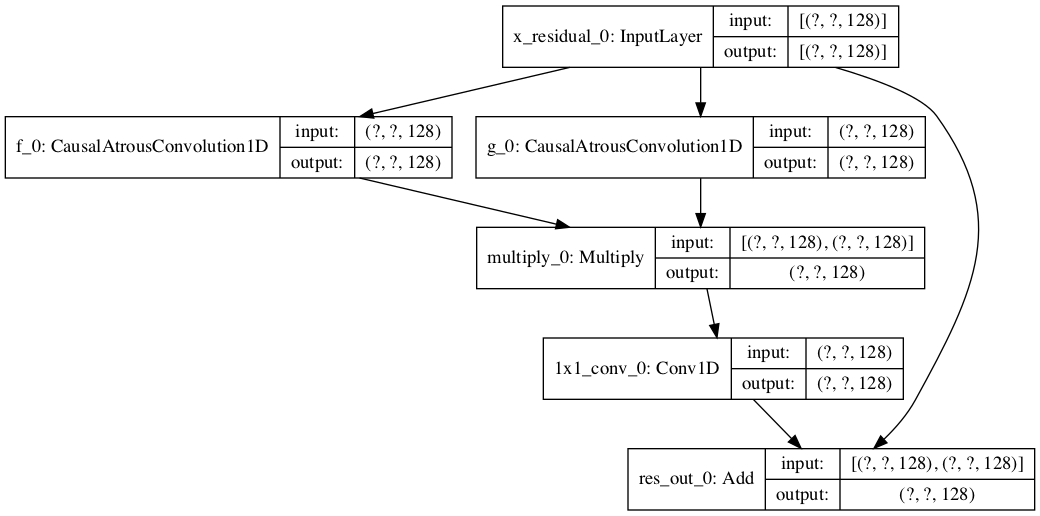

In [109]:
plot_model(wavenet.blocks[0], show_shapes=True)

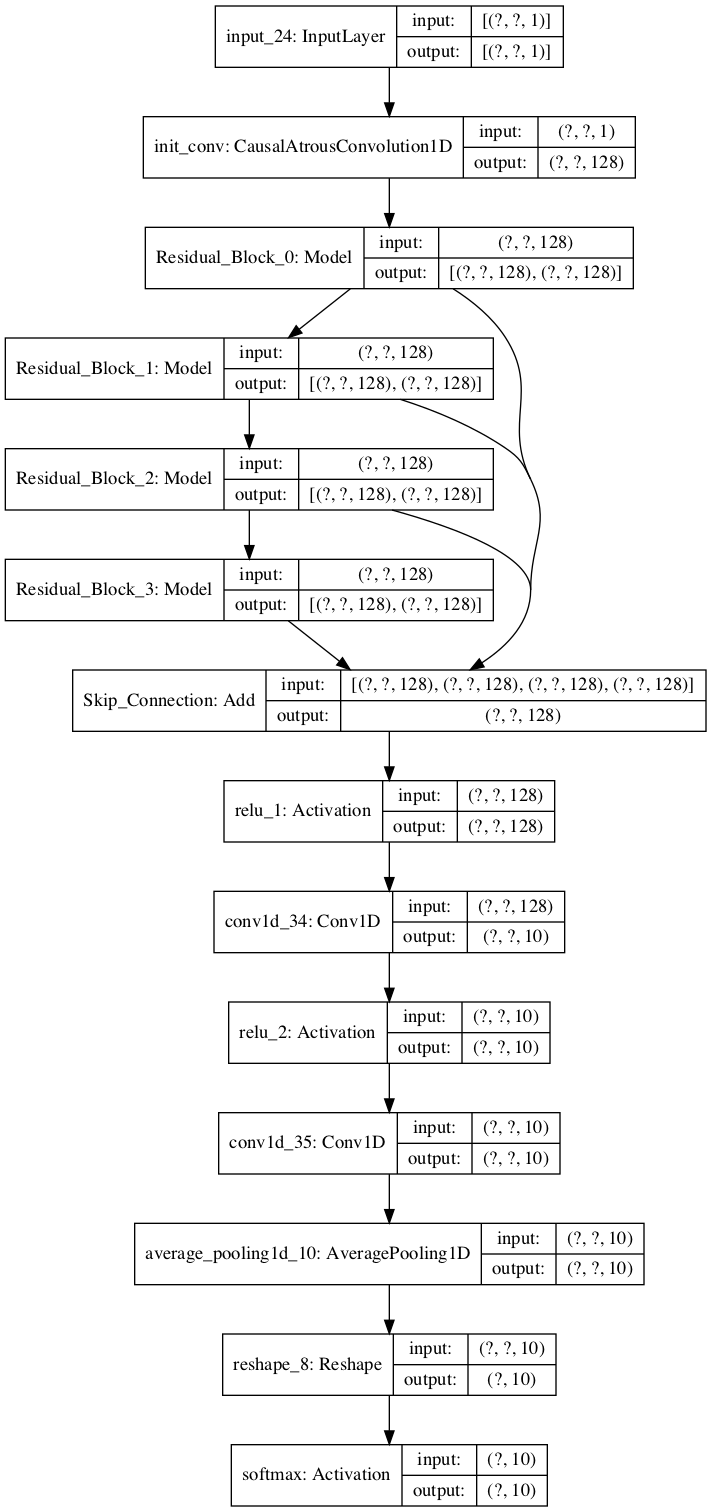

In [110]:
plot_model(wavenet.model, show_shapes=True)

In [106]:
optimizers = tf.keras.optimizers.Adam(learning_rate=1e-3)
loss = tf.keras.losses.CategoricalCrossentropy()
wavenet.compile(optimizer=optimizers, loss=loss)

In [ ]:
from load_